## Exercise set 4: the generalized random forest

In this exercise set we will be working with the [generalized random forest](https://github.com/grf-labs/grf) by Athey et al. The package is written for the R programming language, and while there is a R-to-python interface in [rpy2](https://rpy2.bitbucket.io/) it can be tricky to get working. If you run into trouble, you can consider saving your data to a csv file and work directly in [R](https://www.r-project.org/) through [Rstudio](https://rstudio.com/products/rstudio/download/). 

In [0]:
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

To highlight the usefulness of GRF we will be working with synthetic data in this exercise. In particular we will synthetically add a treatment effect to a dataset in which there otherwise is none. Furthermore we will make this effect heterogeneous by adding noise, and by making it depend on a single continuous variable as well as a categorical variable. 

>**Ex. 4.1.1:** Complete the code below to simulate data according to
$$
T = U(0,1) > 0.5 \\ 
Y(T=0) = X\beta + \epsilon \\ 
\tau(X) =  \begin{cases}
        \frac{10}{1 + e^{-\gamma X_0}} + \nu & D = 0\\ 
        \nu & D = 1
        \end{cases}\\ 
Y(T=1) = Y(0) + \tau(X) \\ 
$$
where $\epsilon, \nu$ are simply noise terms distributed according to $\mathcal{N}(0,1)$ and $\beta$ is an `N_FEATURES` vector of random parameters. $\gamma$ is a scalar parameter.


In [0]:
# Set seed for recreation of data 
np.random.seed(5)
# Scalar specified 
GAMMA = 3

# Feature and sample size 
N_SAMPLES = 10000
N_FEATURES = 5

# Draw uniformly beta coefficients and assign treatment 
BETA = np.random.uniform(0,1, size = N_FEATURES)
T = np.random.uniform(0,1, size = N_SAMPLES) > 0.5

# Draw features and realizations for D - treatment effect 
X = np.random.normal(size = (N_SAMPLES, N_FEATURES))
D = np.random.choice([0,1], size = N_SAMPLES)

# Assign values for outome variable for treatment Y(T=1) and non-treatment Y(T=0)
Y0 = X @ BETA + np.random.normal()
Tau = (1-D)*(10/(1+np.exp(-GAMMA*X[:,0]))) + np.random.normal()
Y1 = Y0 + Tau 

# Outcome variable can be described as - See lecture notes
y = Y0 + T * (Y1 - Y0) 


**Ex. 4.1.2:** Create a two-subplot figure, and plot $Y(0)$ and $Y(1)$ in one subplot against $X_0$. Plot $\tau(x)$ against $X_0$ in the other subplot. What do you see? Why do we observe $\tau=0$ in many cases?

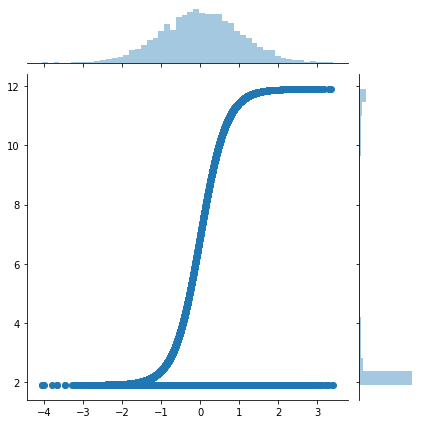

In [3]:
import seaborn as sns
%matplotlib inline
sns.jointplot(X[:,0], Tau)


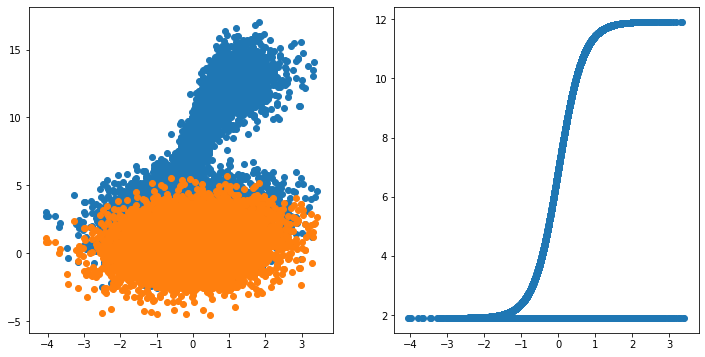

In [4]:
# Your answer here
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.scatter(X[:,0],Y1)
ax.scatter(X[:,0],Y0)

ax = fig.add_subplot(1,2,2)
ax.scatter(X[:,0],Tau)

In [0]:
# Comments: 
# Above we see the difference in the treatment effects.
# Notice we get tau = 0 in many cases, when nu (v) = 0
# This is because nu is a standard normally distribution random variable N(0,1)

>**Ex 4.1.3.** Import `statsmodels` and estimate a simple linear regression
$$
y = \alpha + \delta_0 T + \sum_k \beta_k X_k + \epsilon
$$
>What is your estimate of $\hat{\delta}_0$? How does this number fit with the figures you drew in the previous exercise? Do you have any suggestions for improving the estimate of the model, comment on whether your improvements would provide unbiased estimates of $\tau$? 
>
> **Bonus:** fit your improved model, and relate the parameters you estimate to the figure you plotted in the previous question.

In [38]:
# Your answer here
import statsmodels.api as sm
from patsy import dmatrices

y, X_cons = dmatrices('y ~ + T + X')
print(X_cons)

[[ 1.          1.         -0.23967382 ...  0.29824426  0.38728735
   2.27139476]
 [ 1.          1.          1.20550271 ... -0.06580057  0.96874037
  -2.08261995]
 [ 1.          1.         -0.29915526 ...  0.32775133  0.97091645
   1.2270708 ]
 ...
 [ 1.          0.         -2.64923719 ... -0.29770504 -0.05833215
  -0.88578658]
 [ 1.          0.          0.47486621 ... -1.61158276 -0.23039479
  -0.79418852]
 [ 1.          0.         -1.17228683 ... -0.25691137 -0.72180495
   0.6947227 ]]


In [40]:
model = sm.OLS(y,X_cons)
results = model.fit()
results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     2197.
Date:                Mon, 16 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:42:37   Log-Likelihood:                -22997.
No. Observations:               10000   AIC:                         4.601e+04
Df Residuals:                    9993   BIC:                         4.606e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7265      0.034     21.276      0.0

In [46]:
# From reading the model T[T.True] gives us 4.3533 as an estimate.

# This estimate fit nicely the estimate from the figures before:
np.mean(Tau)[1]

4.394256783224497

>**Ex. 4.1.4:** For this question we will need to move into R (or use rpy2). If you are working in python you can skip this step, otherwise do the following. 
>
> Save a dataframe, containing $X$, $y$, $T$, and $D$ as a csv file on your computer.

In [0]:
# Dataframe for storing variables
data=pd.DataFrame(X, columns=['X0', 'X1', 'X2', 'X3', 'X4']) 
#data = pd.DataFrame(X)
data['y'] = y
data['D'] = D
data['T'] = T
data.head()
# Export to csv-file for use in R 

from google.colab import files
data.to_csv('data.csv') 
files.download('data.csv')

>**Ex. 4.1.5:** Open up R and read the data you just saved into a dataframe(or work in rpy2). Install and load the two libraries `tidyverse` and `grf`.
>
> _Hint:_ to install the required packages. run this:
> ```R
> install.packages("tidyverse")
> install.packages("grf")
> ```

In [0]:
# Your answer either here, or in R

# COPY THIS CODE BELOW IN R: 

setwd(dirname(rstudioapi::getActiveDocumentContext()$path))
# install.packages("rstudioapi")

# Ex. 4.1.5
install.packages("tidyverse")
install.packages("grf")
library(magrittr)
library(dplyr)
library(grf)

df <- read.csv(file = 'data.csv')

X <- df %>%
  select(X0, X1, X2, X3, X4, D) %>% 
  as.matrix()

y <- df %>%
  select(y) %>% 
  as.matrix()

W <- df %>%
  select(T) %>% 
  as.matrix()

for (i in 1:length(W)){
  if( W[i]=="True"){
    W[i] = 1
  }
  else if (W[i] == "False"){
    W[i] = 0
  }
}

W = as.numeric(W)

# Estimating the GRF model in R:
tau.forest <- causal_forest(X, y, W)
tau <- predict(tau.forest, X)

write.csv(tau, "individual_treatment_effects.csv")

>**Ex. 4.1.5:** Copy the following code into R to split your dataframe into two matrices, `X`, and `y`. Implement the exact same procedure to create a third matrix `W` which contains the treatment indicator (**Note** `T` is a reserved name in R, so name your third matrix `W`).
>```R
>X <- df %>%
  select(X0, X1, X2, X3, X4, D) %>% 
  as.matrix()
>
>y <- df %>%
  select(y) %>% 
  as.matrix()
>```
> Finally spend some time poking around the [GRF documentation](https://github.com/grf-labs/grf). See if you can figure out how to estimate a GRF model, once you have the three matrices you need (this is way simpler than you might expect).

In [0]:
# Your answer either here, or in R

>**Ex.4.1.6:** Estimate a causal forest model using the GRF package, and store the result in a new variable `cf`. Then use the following line to create a dataframe of predicted treatment effects on the same data that you trained the model on. 
>```R
>cf <- # Estimate a generalized RF model aimed at treatment effects.
>tau <- predict(cf, X)
>```
> Once you have your individual treatment effects, run the following line, to save them in a csv file. 
> ```R
> write.csv(tau, "individual_treatment_effects.csv")
> ```

In [0]:
# Your answer either here, or in R

>**Ex.4.1.6:** This concludes our venture into R. Now load the treatment effects into a pandas dataframe, and plot a scatterplot of the estimated individual treatment effects against the simulated "true" ITE's `Tau` that you produced in the beginning of this exercise set.

      Unnamed: 0  predictions
0              1     4.700523
1              2    11.144478
2              3     1.869538
3              4     8.479717
4              5     1.931558
...          ...          ...
9995        9996    11.780341
9996        9997     1.907769
9997        9998     2.092843
9998        9999     9.879901
9999       10000     2.278354

[10000 rows x 2 columns]


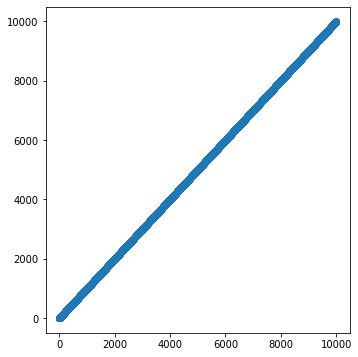

In [35]:
# Your answer either here
#url = 'https://jumpshare.com/v/7T2mZawWaS4Np35Ef0UE'
#url = 'https://jmp.sh/BfPjt9G'
url = 'https://raw.githubusercontent.com/jacobshein/uploads/master/individual_treatment_effects.csv'

Tau = pd.read_csv(url)
#preds = pd.read_csv(url, error_bad_lines=False)
#df = pd.read_csv(url, sep='delimiter', header=None)

print(preds)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,2)
ax.scatter(preds,Tau)

# Our predictions lie exactly ontop of the actual/simulated DGP.